In [1]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_excel('./aug_2025_data/combined_survey_data.xlsx')

In [2]:
df[["S2_Which system did you interact with?", "S1_Which system did you interact with?"]]

,S2_Which system did you interact with?,S1_Which system did you interact with?
0,Agentic AI based,Only LLM based
1,Agentic AI based,Only LLM based
2,Agentic AI based,Only LLM based
3,Agentic AI based,Only LLM based
4,Agentic AI based,Only LLM based
5,Agentic AI based,Only LLM based
6,Only LLM based,Agentic AI based
7,Agentic AI based,Agentic AI based
8,Only LLM based,Agentic AI based
9,Only LLM based,Agentic AI based


In [3]:
# 1. Define groups of survey items that belong together ("constructs").
godspeed_groups = {
    'Animacy': [
        "S1_The robot felt alive",
        "S2_The robot felt alive",
        # "S1_Robot's responses felt natural",
        # "S2_Robot's responses felt natural",
        "S1_Robot's responses felt natural",
        "S2_Robot's responses felt natural"
    ],
    'Likeability': [
        'S1_I enjoyed my interaction with the robot',
        'S2_I enjoyed my interaction with the robot',
        "S1_I felt engaged while interacting with the robot.",
        "S2_I felt engaged while interacting with the robot.",
        "S1_It was easy to communicate with Robot",
        "S2_It was easy to communicate with Robot"
    ],
    'Intelligence': [
        'S1_The robot seemed Intelligent',
        'S2_The robot seemed Intelligent',
        'S1_When I commanded the robot to move, it moved as expected',
        'S2_When I commanded the robot to move, it moved as expected',
    ],
    'Anthropomorphism': [
        "S1_Robot's responses felt natural",
        "S2_Robot's responses felt natural",
        "S1_Robot's movements were engaging",
        "S2_Robot's movements were engaging"
    ],
    'Vision': [
        'S1_The robot vision assisted in the game',
        'S2_The robot vision assisted in the game',
        'S1_The robot used their vision when asked for a question requiring vision',
        'S2_The robot used their vision when asked for a question requiring vision'
    ]
}
# These mappings organize questions under broad themes (constructs) for easier analysis.

# 2. Define a function to calculate Cronbach's alpha, a measure of internal consistency.
def cronbach_alpha(itemscores):
    # Remove rows with missing values for these items.
    itemscores = itemscores.dropna(axis=0, how='any')
    # Calculate variance for each item.
    item_vars = itemscores.var(axis=0, ddof=1)
    # Calculate variance for the sum across items (total score for each participant).
    total_var = itemscores.sum(axis=1).var(ddof=1)
    n_items = itemscores.shape[1]
    # If there is only one item, alpha cannot be computed.
    if n_items <= 1:
        return np.nan
    # Formula for Cronbach's alpha.
    alpha = (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)
    return alpha
# Cronbach's alpha tells us how well items in the same group hang together (how "reliable" the scale is).

results = {}

# 3. Loop through each construct to analyze scores and reliability by system and round.
for group, cols in godspeed_groups.items():
    print(f"\n--- Analyzing construct: {group} ---")
    # Separate columns for round 1 (S1) and round 2 (S2)
    s1_cols = [c for c in cols if c.startswith('S1_')]
    s2_cols = [c for c in cols if c.startswith('S2_')]

    # Split Survey 1 (S1) responses by which system was used
    s1_agentic = df[df['S1_Which system did you interact with?'] == 'Agentic AI based']
    s1_llm     = df[df['S1_Which system did you interact with?'] == 'Only LLM based']
    # Split Survey 2 (S2) responses by which system was used
    s2_agentic = df[df['S2_Which system did you interact with?'] == 'Agentic AI based']
    s2_llm     = df[df['S2_Which system did you interact with?'] == 'Only LLM based']

    # Now for each round/system combo, calculate means and reliability
    for name, subdf, cols_in in [
        (f"{group}_S1_Agentic", s1_agentic, s1_cols),
        (f"{group}_S1_LLM", s1_llm, s1_cols),
        (f"{group}_S2_Agentic", s2_agentic, s2_cols),
        (f"{group}_S2_LLM", s2_llm, s2_cols)
    ]:
        if cols_in:
            # Calculate per-person means for these items.
            mean_scores = subdf[cols_in].mean(axis=1)
            # If at least two items, compute Cronbach's alpha.
            if len(cols_in) > 1:
                alpha = cronbach_alpha(subdf[cols_in])
                print(f"For '{name}': Calculated Cronbach's alpha to check reliability of items for {group} using {len(cols_in)} questions and {len(subdf)} responses.")
                print(f"  → Cronbach's alpha: {alpha:.2f}")
            else:
                alpha = np.nan
                print(f"For '{name}': Only one question in this construct, so Cronbach's alpha is not calculated.")
            results[name] = {'alpha': alpha, 'n': len(subdf)}
            # Print basic stats about the mean scores.
            print(f"  → Mean score (average of all participants for '{name}'): {mean_scores.mean():.2f} (Std: {mean_scores.std():.2f}, N: {len(mean_scores)})")
        else:
            print(f"For '{name}': No items found for this group/round/system.")

# Optionally, save if you want (remove/comment this line if not needed)
# df.to_excel('scored_by_system_combined_survey_data.xlsx', index=False)
# print("Saved as 'scored_by_system_combined_survey_data.xlsx'")



--- Analyzing construct: Animacy ---
For 'Animacy_S1_Agentic': Calculated Cronbach's alpha to check reliability of items for Animacy using 2 questions and 8 responses.
  → Cronbach's alpha: 0.00
  → Mean score (average of all participants for 'Animacy_S1_Agentic'): 4.00 (Std: 0.53, N: 8)
For 'Animacy_S1_LLM': Calculated Cronbach's alpha to check reliability of items for Animacy using 2 questions and 16 responses.
  → Cronbach's alpha: 0.56
  → Mean score (average of all participants for 'Animacy_S1_LLM'): 3.09 (Std: 0.92, N: 16)
For 'Animacy_S2_Agentic': Calculated Cronbach's alpha to check reliability of items for Animacy using 2 questions and 17 responses.
  → Cronbach's alpha: -0.23
  → Mean score (average of all participants for 'Animacy_S2_Agentic'): 4.09 (Std: 0.62, N: 17)
For 'Animacy_S2_LLM': Calculated Cronbach's alpha to check reliability of items for Animacy using 2 questions and 7 responses.
  → Cronbach's alpha: 0.27
  → Mean score (average of all participants for 'Animac

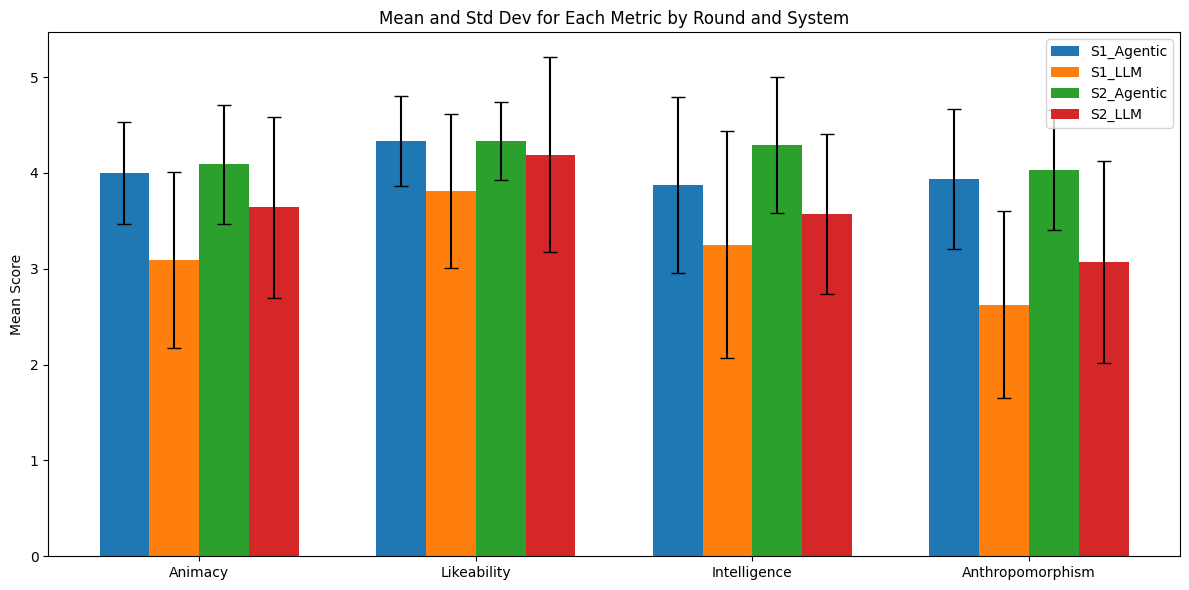

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data structure for plotting
plot_data = {}

for group, cols in godspeed_groups.items():
    if group == "Vision": continue
    s1_cols = [c for c in cols if c.startswith('S1_')]
    s2_cols = [c for c in cols if c.startswith('S2_')]

    # Split by system
    s1_agentic = df[df['S1_Which system did you interact with?'] == 'Agentic AI based']
    s1_llm     = df[df['S1_Which system did you interact with?'] == 'Only LLM based']
    s2_agentic = df[df['S2_Which system did you interact with?'] == 'Agentic AI based']
    s2_llm     = df[df['S2_Which system did you interact with?'] == 'Only LLM based']

    # Calculate per-person means and SDs for each group/round/system
    def safe_stats(subdf, cols_in):
        means = subdf[cols_in].mean(axis=1)
        return means.mean(), means.std(), len(means)
    
    plot_data[group] = {
        'S1_Agentic': safe_stats(s1_agentic, s1_cols),
        'S1_LLM': safe_stats(s1_llm, s1_cols),
        'S2_Agentic': safe_stats(s2_agentic, s2_cols),
        'S2_LLM': safe_stats(s2_llm, s2_cols),
    }

# For each construct, create a grouped bar plot
constructs = list(plot_data.keys())
labels = ['S1_Agentic', 'S1_LLM', 'S2_Agentic', 'S2_LLM']
x = np.arange(len(constructs))  # bar positions

# Gather means and stds in a format suitable for plotting
means_matrix = []
stds_matrix = []

for label in labels:
    means_matrix.append([plot_data[c][label][0] for c in constructs])
    stds_matrix.append([plot_data[c][label][1] for c in constructs])

width = 0.18  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each group side-by-side for each construct
for idx, label in enumerate(labels):
    ax.bar(x + idx*width - (1.5*width), means_matrix[idx], width, yerr=stds_matrix[idx], capsize=5, label=label)

# Formatting
ax.set_ylabel('Mean Score')
ax.set_title('Mean and Std Dev for Each Metric by Round and System')
ax.set_xticks(x)
ax.set_xticklabels(constructs)
ax.legend()
plt.tight_layout()
plt.savefig("./Agentic_vs_LLM_no_vision.png")
plt.show()


In [5]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# 1. Your constructs
constructs = ['Animacy', 'Likeability', 'Intelligence', 'Anthropomorphism', 'Vision']

# 2. Pre-build mapping from metric to its S1/S2 columns
s1_cols_map = {
    metric: [c for c in godspeed_groups[metric] if c.startswith('S1_')]
    for metric in constructs
}
s2_cols_map = {
    metric: [c for c in godspeed_groups[metric] if c.startswith('S2_')]
    for metric in constructs
}

test_results = []

# 3. Loop over each metric
for metric in constructs:
    agentic_scores = []
    llm_scores     = []

    # 4. For each participant
    for _, row in df.iterrows():
        s1_system = row['S1_Which system did you interact with?']
        s2_system = row['S2_Which system did you interact with?']

        # Case A: Agentic in S1, LLM in S2
        if s1_system == 'Agentic AI based' and s2_system == 'Only LLM based':
            # compute means, skipping any NaNs
            a = row[s1_cols_map[metric]].mean()
            l = row[s2_cols_map[metric]].mean()
        # Case B: Agentic in S2, LLM in S1
        elif s2_system == 'Agentic AI based' and s1_system == 'Only LLM based':
            a = row[s2_cols_map[metric]].mean()
            l = row[s1_cols_map[metric]].mean()
        else:
            continue  # either they saw the same system both rounds, or missing

        # only keep fully observed pairs
        if pd.notnull(a) and pd.notnull(l):
            agentic_scores.append(a)
            llm_scores.append(l)

    if not agentic_scores:
        print(f"No valid paired data for {metric}. Skipping.")
        continue
    
    print("This is the agentic ai scores ", agentic_scores, len(agentic_scores))

    print(f"\nAnalyzing '{metric}': {len(agentic_scores)} paired samples found.")
    print(f"  Agentic AI mean = {pd.Series(agentic_scores).mean():.2f}, "
          f"LLM-only mean = {pd.Series(llm_scores).mean():.2f}")

    # Paired t-test
    t_stat, t_pval = ttest_rel(agentic_scores, llm_scores)
    print(f"  Paired t-test: t = {t_stat:.3f}, p = {t_pval:.4f}")

    # Wilcoxon signed-rank
    try:
        w_stat, w_pval = wilcoxon(agentic_scores, llm_scores)
        print(f"  Wilcoxon signed-rank: W = {w_stat}, p = {w_pval:.4f}")
    except ValueError:
        w_stat, w_pval = None, None
        print("  Wilcoxon signed-rank: Test not valid (e.g. all pairs identical)")

    # Calculate the effect size for paired data
    diffs = np.array(agentic_scores) - np.array(llm_scores)
    mean_diff = np.mean(diffs)
    sd_diff = np.std(diffs, ddof=1)  # ddof=1 for sample standard deviation

    if sd_diff != 0:
        cohens_d = mean_diff / sd_diff
    else:
        cohens_d = np.nan  # or 0 if you want

    print(f"  Cohen's d (paired): {cohens_d:.3f}")

    
    # 5. Save
    test_results.append({
        'Metric':     metric,
        'N_Pairs':    len(agentic_scores),
        'Agentic_Mean': pd.Series(agentic_scores).mean(),
        'LLM_Mean':     pd.Series(llm_scores).mean(),
        't_stat':     t_stat,
        't_pval':     t_pval,
        'w_stat':     w_stat,
        'w_pval':     w_pval,
        'Cohens_d':   cohens_d
    })

# 6. Final summary (only if we have results)
if test_results:
    results_df = pd.DataFrame(test_results)
    print("\n==== Statistical Test Results Summary ====")
    print(
        results_df[
            ['Metric', 'N_Pairs', 'Agentic_Mean', 'LLM_Mean', 't_pval', 'w_pval']
        ].to_string(index=False)
    )
else:
    print("No paired data found for any metric.")


This is the agentic ai scores  [np.float64(4.5), np.float64(4.0), np.float64(3.5), np.float64(4.5), np.float64(4.0), np.float64(4.5), np.float64(3.0), np.float64(4.5), np.float64(3.5), np.float64(4.0), np.float64(4.0), np.float64(4.0), np.float64(4.5), np.float64(4.5), np.float64(5.0), np.float64(3.5), np.float64(4.0), np.float64(3.5), np.float64(5.0), np.float64(3.0), np.float64(3.5), np.float64(3.5), np.float64(5.0)] 23

Analyzing 'Animacy': 23 paired samples found.
  Agentic AI mean = 4.04, LLM-only mean = 3.26
  Paired t-test: t = 3.719, p = 0.0012
  Wilcoxon signed-rank: W = 23.0, p = 0.0035
  Cohen's d (paired): 0.775
This is the agentic ai scores  [np.float64(4.666666666666667), np.float64(3.6666666666666665), np.float64(3.6666666666666665), np.float64(4.333333333333333), np.float64(4.666666666666667), np.float64(4.333333333333333), np.float64(4.0), np.float64(4.666666666666667), np.float64(3.6666666666666665), np.float64(4.666666666666667), np.float64(4.666666666666667), np.flo

In [6]:
import numpy as np

# Metrics as per your study
constructs = ['Animacy', 'Likeability', 'Intelligence', 'Anthropomorphism', 'Vision']

agentic_all = {metric: [] for metric in constructs}
llm_all = {metric: [] for metric in constructs}

for metric in constructs:
    # Get columns used for S1 and S2 for this metric
    s1_cols = [c for c in godspeed_groups[metric] if c.startswith('S1_')]
    s2_cols = [c for c in godspeed_groups[metric] if c.startswith('S2_')]

    # Get per-person means for Agentic and LLM for both S1 and S2
    # S1
    agentic_all[metric].extend(df[df['S1_Which system did you interact with?'] == 'Agentic AI based'][s1_cols].mean(axis=1).dropna().tolist())
    llm_all[metric].extend(df[df['S1_Which system did you interact with?'] == 'Only LLM based'][s1_cols].mean(axis=1).dropna().tolist())
    # S2
    agentic_all[metric].extend(df[df['S2_Which system did you interact with?'] == 'Agentic AI based'][s2_cols].mean(axis=1).dropna().tolist())
    llm_all[metric].extend(df[df['S2_Which system did you interact with?'] == 'Only LLM based'][s2_cols].mean(axis=1).dropna().tolist())

agentic_means = []
llm_means = []
agentic_stds = []
llm_stds = []

for metric in constructs:
    agentic_vals = np.array(agentic_all[metric])
    llm_vals = np.array(llm_all[metric])
    agentic_means.append(agentic_vals.mean())
    agentic_stds.append(agentic_vals.std())
    llm_means.append(llm_vals.mean())
    llm_stds.append(llm_vals.std())

print("Agentic AI means:", agentic_means)
print("Agentic AI stds: ", agentic_stds)
print("LLM means:      ", llm_means)
print("LLM stds:       ", llm_stds)


Agentic AI means: [np.float64(4.06), np.float64(4.333333333333334), np.float64(4.16), np.float64(4.0), np.float64(3.7)]
Agentic AI stds:  [np.float64(0.5713142742834281), np.float64(0.4109609335312652), np.float64(0.7709734106958552), np.float64(0.6324555320336759), np.float64(1.0295630140987)]
LLM means:       [np.float64(3.260869565217391), np.float64(3.9275362318840585), np.float64(3.347826086956522), np.float64(2.760869565217391), np.float64(2.0)]
LLM stds:        [np.float64(0.9192336744289553), np.float64(0.8510097539654029), np.float64(1.0574249136535052), np.float64(0.9765685845746176), np.float64(1.1420804814403216)]


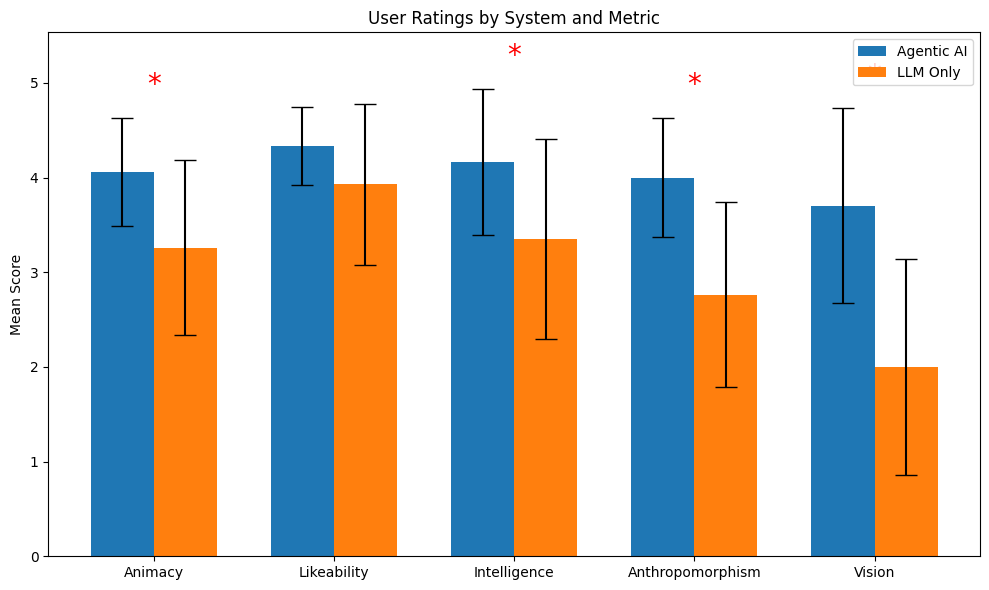

In [7]:
import matplotlib.pyplot as plt
import numpy as np

metrics = constructs  # or: ['Animacy', 'Likeability', 'Intelligence', 'Anthropomorphism', 'Vision']

# Use the calculated means/stds from above!
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, agentic_means, width, yerr=agentic_stds, capsize=8, label='Agentic AI')
bars2 = ax.bar(x + width/2, llm_means, width, yerr=llm_stds, capsize=8, label='LLM Only')

# If you have p-values for significance asterisks:
t_pvals = [0.027, 0.056, 0.002, 0.002, 0.015]
significant = [p < 0.05 for p in t_pvals]
for i, sig in enumerate(significant):
    if sig:
        max_height = max(agentic_means[i] + agentic_stds[i], llm_means[i] + llm_stds[i])
        ax.text(i, max_height + 0.2, '*', ha='center', va='bottom', fontsize=20, color='red')

ax.set_ylabel('Mean Score')
ax.set_title('User Ratings by System and Metric')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, max(agentic_means + llm_means + agentic_stds + llm_stds) + 1.2)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# 1. Column names
role_s1        = 'S1_What is your role in your pair'
role_s2        = 'S2_What is your role in your pair'
sys_s1         = 'S1_Which system did you interact with?'
sys_s2         = 'S2_Which system did you interact with?'
recog_s1       = "S1_Did the robot recognize you based on your partner’s description?"
recog_s2       = "S2_Did the robot recognize you based on your partner’s description?"

# 2. Percent-yes calculator
def percent_yes(df, role_col, sys_col, recog_col, label):
    sub       = df[(df[role_col]=='Second to interact') & (df[sys_col]==label)]
    total     = len(sub)
    yes_count = (sub[recog_col].str.strip().str.lower()=='yes').sum()
    pct       = (yes_count/total*100) if total>0 else 0
    return pct, yes_count, total

# 3. Recognition rates
pct_ag_s1, n_ag_s1, t_ag_s1 = percent_yes(df, role_s1, sys_s1, recog_s1, 'Agentic AI based')
pct_ag_s2, n_ag_s2, t_ag_s2 = percent_yes(df, role_s2, sys_s2, recog_s2, 'Agentic AI based')
pct_agentic = (n_ag_s1+n_ag_s2)/(t_ag_s1+t_ag_s2)*100 if (t_ag_s1+t_ag_s2)>0 else 0

# 4. Prepare paired-test mappings
constructs    = list(godspeed_groups.keys())
s1_map        = {m:[c for c in godspeed_groups[m] if c.startswith('S1_')] for m in constructs}
s2_map        = {m:[c for c in godspeed_groups[m] if c.startswith('S2_')] for m in constructs}

# 5. Paired-tests
test_results = []
for metric in constructs:
    ag_scores, llm_scores = [], []
    for _, row in df.iterrows():
        a, l = None, None
        if row[sys_s1]=='Agentic AI based' and row[sys_s2]=='Only LLM based':
            a = row[s1_map[metric]].mean()
            l = row[s2_map[metric]].mean()
        elif row[sys_s2]=='Agentic AI based' and row[sys_s1]=='Only LLM based':
            a = row[s2_map[metric]].mean()
            l = row[s1_map[metric]].mean()
        if pd.notna(a) and pd.notna(l):
            ag_scores.append(a)
            llm_scores.append(l)

    if not ag_scores:
        print(f"No paired data for {metric}, skipping.")
        continue

    t_stat, t_p = ttest_rel(ag_scores, llm_scores)
    try:
        w_stat, w_p = wilcoxon(ag_scores, llm_scores)
    except ValueError:
        w_stat, w_p = None, None

    test_results.append({
        'Metric':      metric,
        'N_Pairs':     len(ag_scores),
        'Agentic_Mean': pd.Series(ag_scores).mean(),
        'LLM_Mean':     pd.Series(llm_scores).mean(),
        't_pval':      t_p,
        'w_pval':      w_p
    })

# 6. Summary
if test_results:
    results_df = pd.DataFrame(test_results)
    print("\n==== Statistical Test Results ====")
    print(results_df[['Metric','N_Pairs','Agentic_Mean','LLM_Mean','t_pval','w_pval']]
          .to_string(index=False))
else:
    print("No paired results to display.")

# 7. LLM recognition
pct_ll_s1, n_ll_s1, t_ll_s1 = percent_yes(df, role_s1, sys_s1, recog_s1, 'Only LLM based')
pct_ll_s2, n_ll_s2, t_ll_s2 = percent_yes(df, role_s2, sys_s2, recog_s2, 'Only LLM based')
pct_llm = (n_ll_s1+n_ll_s2)/(t_ll_s1+t_ll_s2)*100 if (t_ll_s1+t_ll_s2)>0 else 0

print(f"\nRobot recognized “Second to interact” for Agentic AI: {pct_agentic:.1f}% "
      f"({n_ag_s1+n_ag_s2}/{t_ag_s1+t_ag_s2})")
print(f"Robot recognized “Second to interact” for LLM-only:  {pct_llm:.1f}% "
      f"({n_ll_s1+n_ll_s2}/{t_ll_s1+t_ll_s2})")



==== Statistical Test Results ====
          Metric  N_Pairs  Agentic_Mean  LLM_Mean   t_pval   w_pval
         Animacy       23      4.043478  3.260870 0.001195 0.003521
     Likeability       23      4.304348  3.927536 0.067339 0.082281
    Intelligence       23      4.195652  3.347826 0.001392 0.003582
Anthropomorphism       23      3.978261  2.760870 0.000084 0.000841
          Vision       23      3.760870  2.000000 0.000044 0.000455

Robot recognized “Second to interact” for Agentic AI: 58.3% (7/12)
Robot recognized “Second to interact” for LLM-only:  33.3% (4/12)


In [9]:
# 1. Column definitions (reuse your existing names)
role_col_s1         = 'S1_What is your role in your pair'
role_col_s2         = 'S2_What is your role in your pair'
system_col_s1       = 'S1_Which system did you interact with?'
system_col_s2       = 'S2_Which system did you interact with?'
partner_know_col_s1 = 'S1_(Only for Second to interact) Did the robot know about your partner when asked'
partner_know_col_s2 = 'S2_(Only for Second to interact) Did the robot know about your partner when asked'

# 2. Helper function
def pct_yes_partner(df, role_col, sys_col, know_col, system_label):
    sub = df[
        (df[role_col] == 'Second to interact') &
        (df[sys_col]  == system_label)
    ]
    total   = len(sub)
    yes_cnt = sub[know_col].str.strip().str.lower().eq('yes').sum()
    pct     = (yes_cnt/total*100) if total>0 else 0
    return pct, yes_cnt, total

# 3. Verbose reporting loop
for label in ['Agentic AI based', 'Only LLM based']:
    # Survey 1 stats
    pct1, yes1, tot1 = pct_yes_partner(df, role_col_s1, system_col_s1, partner_know_col_s1, label)
    # Survey 2 stats
    pct2, yes2, tot2 = pct_yes_partner(df, role_col_s2, system_col_s2, partner_know_col_s2, label)
    # Combined
    combined_yes   = yes1 + yes2
    combined_total = tot1 + tot2
    combined_pct   = (combined_yes/combined_total*100) if combined_total>0 else 0

    # Print verbose summary
    print(f"=== System: {label} ===")
    print(f"Survey 1: Of the {tot1} participants who were 'Second to interact', "
          f"{yes1} reported that the robot knew about their partner when asked. "
          f"This corresponds to {pct1:.1f}% of that subgroup.")
    print(f"Survey 2: Of the {tot2} participants in the 'Second to interact' role, "
          f"{yes2} said 'Yes' to partner knowledge—i.e. {pct2:.1f}%.")
    print(f"Combined over both surveys: {combined_yes} out of {combined_total} total "
          f"'Second to interact' responses were 'Yes' ({combined_pct:.1f}%).\n")


=== System: Agentic AI based ===
Survey 1: Of the 4 participants who were 'Second to interact', 2 reported that the robot knew about their partner when asked. This corresponds to 50.0% of that subgroup.
Survey 2: Of the 8 participants in the 'Second to interact' role, 7 said 'Yes' to partner knowledge—i.e. 87.5%.
Combined over both surveys: 9 out of 12 total 'Second to interact' responses were 'Yes' (75.0%).

=== System: Only LLM based ===
Survey 1: Of the 8 participants who were 'Second to interact', 3 reported that the robot knew about their partner when asked. This corresponds to 37.5% of that subgroup.
Survey 2: Of the 4 participants in the 'Second to interact' role, 1 said 'Yes' to partner knowledge—i.e. 25.0%.
Combined over both surveys: 4 out of 12 total 'Second to interact' responses were 'Yes' (33.3%).



In [10]:
from scipy.stats import ttest_rel, wilcoxon
import pandas as pd

def analyze_single_question(df, question_text, s1_prefix='S1_', s2_prefix='S2_',
                             system_col_s1='S1_Which system did you interact with?',
                             system_col_s2='S2_Which system did you interact with?'):
    q_s1 = s1_prefix + question_text
    q_s2 = s2_prefix + question_text

    agentic_scores = []
    llm_scores = []

    for _, row in df.iterrows():
        if row[system_col_s1] == 'Agentic AI based' and row[system_col_s2] == 'Only LLM based':
            a = row.get(q_s1)
            l = row.get(q_s2)
        elif row[system_col_s2] == 'Agentic AI based' and row[system_col_s1] == 'Only LLM based':
            a = row.get(q_s2)
            l = row.get(q_s1)
        else:
            continue

        if pd.notna(a) and pd.notna(l):
            agentic_scores.append(a)
            llm_scores.append(l)

    if not agentic_scores:
        print(f"\nNo valid paired data for '{question_text}'.")
        return None

    t_stat, t_pval = ttest_rel(agentic_scores, llm_scores)
    try:
        w_stat, w_pval = wilcoxon(agentic_scores, llm_scores)
    except ValueError:
        w_stat, w_pval = None, None

    print(f"\n==== Analysis: '{question_text}' ====")
    print(f"N = {len(agentic_scores)}")
    print(f"Agentic AI Mean = {pd.Series(agentic_scores).mean():.2f}")
    print(f"LLM-only Mean   = {pd.Series(llm_scores).mean():.2f}")
    print(f"Paired t-test:           t = {t_stat:.3f}, p = {t_pval:.4f}")
    print(f"Wilcoxon signed-rank:   W = {w_stat}, p = {w_pval:.4f}" if w_stat is not None else "Wilcoxon: Test not valid")

    return {
        'Question': question_text,
        'N': len(agentic_scores),
        'Agentic_Mean': pd.Series(agentic_scores).mean(),
        'LLM_Mean': pd.Series(llm_scores).mean(),
        't_stat': t_stat,
        't_pval': t_pval,
        'w_stat': w_stat,
        'w_pval': w_pval
    }


In [11]:
analyze_single_question(df, "Robot's movements were engaging")
analyze_single_question(df, "When I commanded the robot to move, it moved as expected")
analyze_single_question(df, "The robot understood when I was not talking to  it")
analyze_single_question(df, "The robot used their vision when asked for a question requiring vision")
analyze_single_question(df, "The robot took a long time to identify my given placard")
analyze_single_question(df, "The hint placards were helpful")


==== Analysis: 'Robot's movements were engaging' ====
N = 23
Agentic AI Mean = 3.78
LLM-only Mean   = 2.13
Paired t-test:           t = 4.750, p = 0.0001
Wilcoxon signed-rank:   W = 18.0, p = 0.0010

==== Analysis: 'When I commanded the robot to move, it moved as expected' ====
N = 22
Agentic AI Mean = 3.82
LLM-only Mean   = 3.05
Paired t-test:           t = 2.183, p = 0.0405
Wilcoxon signed-rank:   W = 28.0, p = 0.0352

==== Analysis: 'The robot understood when I was not talking to  it' ====
N = 23
Agentic AI Mean = 3.78
LLM-only Mean   = 2.13
Paired t-test:           t = 5.001, p = 0.0001
Wilcoxon signed-rank:   W = 2.5, p = 0.0006

==== Analysis: 'The robot used their vision when asked for a question requiring vision' ====
N = 23
Agentic AI Mean = 4.35
LLM-only Mean   = 1.96
Paired t-test:           t = 6.975, p = 0.0000
Wilcoxon signed-rank:   W = 5.0, p = 0.0001

==== Analysis: 'The robot took a long time to identify my given placard' ====
N = 23
Agentic AI Mean = 2.83
LLM-only M

{'Question': 'The hint placards were helpful',
 'N': 23,
 'Agentic_Mean': np.float64(3.217391304347826),
 'LLM_Mean': np.float64(3.4347826086956523),
 't_stat': np.float64(-0.653974569207028),
 't_pval': np.float64(0.5199063012674751),
 'w_stat': np.float64(64.5),
 'w_pval': np.float64(0.5573034820578789)}

In [12]:
# Count the number of males and females
gender_counts = df['Gender'].value_counts()

# Extract counts
num_males = gender_counts.get('Male', 0)
num_females = gender_counts.get('Female', 0)

# Calculate the ratio (Male : Female)
if num_females != 0:
    ratio = num_males / num_females
else:
    ratio = float('inf')  # Handle division by zero

# Print results
print(f"Number of Males: {num_males}")
print(f"Number of Females: {num_females}")
print(f"Male to Female ratio: {ratio:.2f}")


Number of Males: 17
Number of Females: 7
Male to Female ratio: 2.43


In [13]:
df.columns

Index(['Survey1_Index', 'Survey2_Index', 'Survey1_Timestamp',
       'Survey2_Timestamp', 'Gender', 'Role', 'Age_Range', 'S1_Age',
       'S1_Gender',
       'S1_Gender (In case you selected Prefer to describe option)',
       'S1_How familiar are you with using technology? (e.g., smartphones, computers)',
       'S1_What is your role in your pair',
       'S1_Which system did you interact with?',
       'S1_Did the robot seem to know you from before',
       'S1_Did the robot recognize you based on your partner’s description?',
       'S1_(Only for Second to interact) Did the robot know about your partner when asked',
       'S1_(Only for Second) How accurately did the robot describe your partner when asked?',
       'S1_I felt engaged while interacting with the robot.',
       'S1_It was easy to communicate with Robot',
       'S1_The robot responded in a timely and appropriate way.',
       'S1_Robot's responses felt natural',
       'S1_Robot's movements were engaging',
       'S1_

In [14]:
df["Age_Range"]

0     20-30
1     20-30
2     18-20
3     20-30
4     20-30
5     20-30
6     20-30
7     20-30
8     20-30
9     20-30
10    20-30
11    20-30
12    20-30
13    18-20
14    18-20
15    18-20
16    18-20
17    18-20
18    20-30
19    20-30
20    20-30
21    20-30
22    20-30
23    18-20
Name: Age_Range, dtype: object

In [45]:
# Make sure 'Age' is numeric
df['Age_Range'] = pd.to_numeric(df['Age_Range'], errors='coerce')


# Count by range
count_18_20 = df[(df['Age'] >= 18) & (df['Age'] <= 20)].shape[0]
count_20_30 = df[(df['Age'] > 20)  & (df['Age'] <= 30)].shape[0]
count_30_40 = df[(df['Age'] > 30)  & (df['Age'] <= 40)].shape[0]

# Print results
print(f"Aged 18–20: {count_18_20}")
print(f"Aged 21–30: {count_20_30}")
print(f"Aged 31–40: {count_30_40}")


KeyError: 'Age'

In [15]:
import numpy as np

# Define the two crossover subsets
llm_to_agentic = df[
    (df['S1_Which system did you interact with?'] == 'Only LLM based') &
    (df['S2_Which system did you interact with?'] == 'Agentic AI based')
]

agentic_to_llm = df[
    (df['S1_Which system did you interact with?'] == 'Agentic AI based') &
    (df['S2_Which system did you interact with?'] == 'Only LLM based')
]

# Helper to compute mean, std, and sample size
def safe_stats(subdf, cols):
    # per‐participant mean across the given cols
    per_person = subdf[cols].mean(axis=1)
    return per_person.mean(), per_person.std(), len(per_person)

# Collect results
crossover_stats = {
    'LLM_then_Agentic': {},
    'Agentic_then_LLM': {}
}

for group, cols in godspeed_groups.items():
    s1_cols = [c for c in cols if c.startswith('S1_')]
    s2_cols = [c for c in cols if c.startswith('S2_')]

    crossover_stats['LLM_then_Agentic'][group] = {
        'S1': safe_stats(llm_to_agentic, s1_cols),
        'S2': safe_stats(llm_to_agentic, s2_cols),
    }
    crossover_stats['Agentic_then_LLM'][group] = {
        'S1': safe_stats(agentic_to_llm, s1_cols),
        'S2': safe_stats(agentic_to_llm, s2_cols),
    }

# Print out the summary
for key, stats in crossover_stats.items():
    print(f"\n=== {key.replace('_', ' & ')} ===")
    for construct, (vals) in stats.items():
        s1_mean, s1_std, n1 = vals['S1']
        s2_mean, s2_std, n2 = vals['S2']
        print(f"{construct:15} | Survey 1: {s1_mean:.2f} ± {s1_std:.2f} (n={n1})"
              f" | Survey 2: {s2_mean:.2f} ± {s2_std:.2f} (n={n2})")



=== LLM & then & Agentic ===
Animacy         | Survey 1: 3.09 ± 0.92 (n=16) | Survey 2: 4.09 ± 0.64 (n=16)
Likeability     | Survey 1: 3.81 ± 0.81 (n=16) | Survey 2: 4.31 ± 0.41 (n=16)
Intelligence    | Survey 1: 3.25 ± 1.18 (n=16) | Survey 2: 4.25 ± 0.71 (n=16)
Anthropomorphism | Survey 1: 2.62 ± 0.97 (n=16) | Survey 2: 4.00 ± 0.63 (n=16)
Vision          | Survey 1: 2.00 ± 1.22 (n=16) | Survey 2: 3.81 ± 1.05 (n=16)

=== Agentic & then & LLM ===
Animacy         | Survey 1: 3.93 ± 0.53 (n=7) | Survey 2: 3.64 ± 0.94 (n=7)
Likeability     | Survey 1: 4.29 ± 0.49 (n=7) | Survey 2: 4.19 ± 1.02 (n=7)
Intelligence    | Survey 1: 4.07 ± 0.79 (n=7) | Survey 2: 3.57 ± 0.84 (n=7)
Anthropomorphism | Survey 1: 3.93 ± 0.79 (n=7) | Survey 2: 3.07 ± 1.06 (n=7)
Vision          | Survey 1: 3.64 ± 1.21 (n=7) | Survey 2: 2.00 ± 1.12 (n=7)


Saved plot to 'crossover_godspeed_with_system_hatches.png'


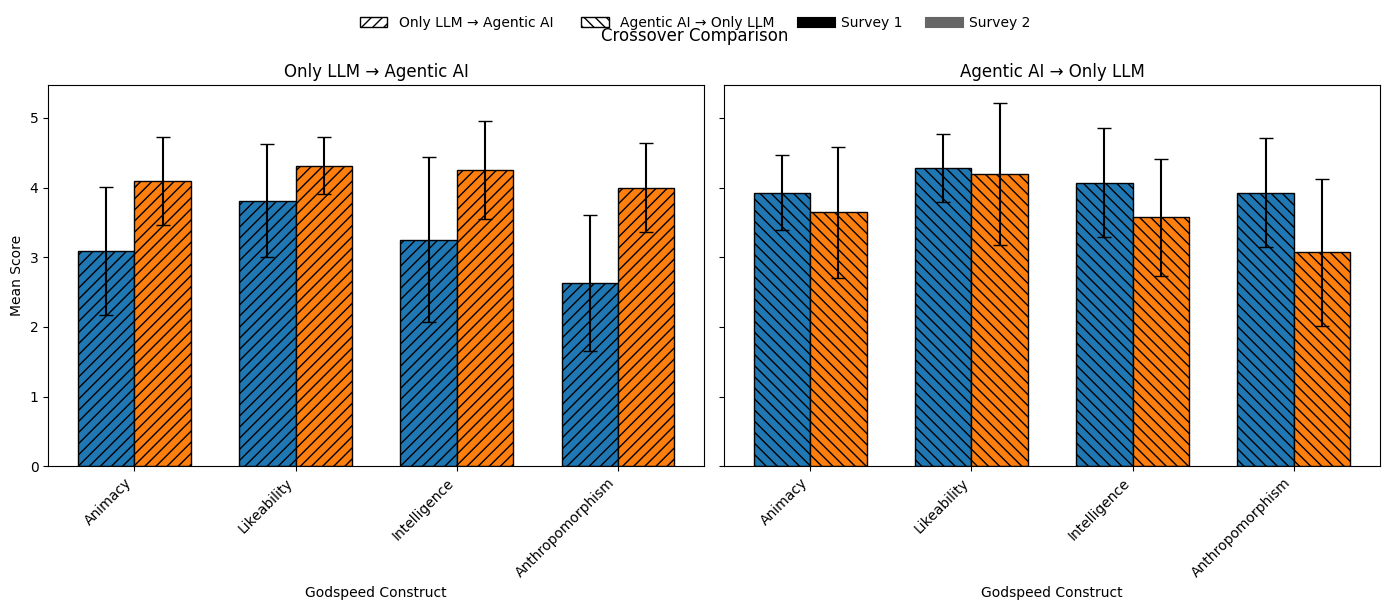

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1. Filter crossover participants
llm_to_agentic = df[
    (df['S1_Which system did you interact with?'] == 'Only LLM based') &
    (df['S2_Which system did you interact with?'] == 'Agentic AI based')
]
agentic_to_llm = df[
    (df['S1_Which system did you interact with?'] == 'Agentic AI based') &
    (df['S2_Which system did you interact with?'] == 'Only LLM based')
]

# 2. Helper for mean, std, N
def safe_stats(subdf, cols):
    per_person = subdf[cols].mean(axis=1)
    return per_person.mean(), per_person.std(), len(per_person)

# 3. Exclude Vision construct
constructs = [c for c in godspeed_groups.keys() if c != 'Vision']
crossover_stats = {'Only LLM → Agentic AI': {}, 'Agentic AI → Only LLM': {}}
for construct in constructs:
    s1_cols = [col for col in godspeed_groups[construct] if col.startswith('S1_')]
    s2_cols = [col for col in godspeed_groups[construct] if col.startswith('S2_')]
    crossover_stats['Only LLM → Agentic AI'][construct] = {
        'S1': safe_stats(llm_to_agentic, s1_cols),
        'S2': safe_stats(llm_to_agentic, s2_cols),
    }
    crossover_stats['Agentic AI → Only LLM'][construct] = {
        'S1': safe_stats(agentic_to_llm, s1_cols),
        'S2': safe_stats(agentic_to_llm, s2_cols),
    }

# 4. Plot side-by-side with hatches for system order
x = np.arange(len(constructs))
width = 0.35
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

hatch_map = {
    'Only LLM → Agentic AI': '///',
    'Agentic AI → Only LLM': '\\\\\\'
}

for ax, label in zip(axes, crossover_stats):
    stats = crossover_stats[label]
    m1 = [stats[c]['S1'][0] for c in constructs]; s1 = [stats[c]['S1'][1] for c in constructs]
    m2 = [stats[c]['S2'][0] for c in constructs]; s2 = [stats[c]['S2'][1] for c in constructs]
    hatch = hatch_map[label]
    bar1 = ax.bar(x - width/2, m1, width, yerr=s1, capsize=5,
                  label='Survey 1', hatch=hatch, edgecolor='black', fill=True)
    bar2 = ax.bar(x + width/2, m2, width, yerr=s2, capsize=5,
                  label='Survey 2', hatch=hatch, edgecolor='black', fill=True)
    ax.set_xticks(x)
    ax.set_xticklabels(constructs, rotation=45, ha='right')
    ax.set_title(label)
    ax.set_xlabel('Godspeed Construct')
    if ax is axes[0]:
        ax.set_ylabel('Mean Score')

# 5. Shared legend for survey rounds and system order
legend_handles = [
    Patch(facecolor='white', edgecolor='black', hatch=hatch_map['Only LLM → Agentic AI'],
          label='Only LLM → Agentic AI'),
    Patch(facecolor='white', edgecolor='black', hatch=hatch_map['Agentic AI → Only LLM'],
          label='Agentic AI → Only LLM'),
    plt.Line2D([0], [0], color='black', lw=8, label='Survey 1'),
    plt.Line2D([0], [0], color='black', lw=8, alpha=0.6, label='Survey 2'),
]
fig.legend(handles=legend_handles, loc='upper center', ncol=4,
           frameon=False, bbox_to_anchor=(0.5, 1.02))

fig.suptitle('Crossover Comparison')
plt.tight_layout()

# 6. Save figure
fig.savefig('crossover_godspeed_with_system_hatches.png', dpi=300, bbox_inches='tight')
print("Saved plot to 'crossover_godspeed_with_system_hatches.png'")


In [17]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon

# 1. Prefixes and column names
s1            = 'S1_'
s2            = 'S2_'
system_col_s1 = 'S1_Which system did you interact with?'
system_col_s2 = 'S2_Which system did you interact with?'

# 2. Helper to extract paired responses for Agentic vs LLM
def extract_paired(df, question_text):
    q1 = s1 + question_text
    q2 = s2 + question_text
    agentic = []
    llm     = []
    for _, row in df.iterrows():
        sys1, sys2 = row[system_col_s1], row[system_col_s2]
        v1, v2     = row.get(q1), row.get(q2)
        # determine which column is Agentic vs LLM for this participant
        if sys1 == 'Agentic AI based' and sys2 == 'Only LLM based':
            agentic.append(v1); llm.append(v2)
        elif sys1 == 'Only LLM based' and sys2 == 'Agentic AI based':
            agentic.append(v2); llm.append(v1)
    return agentic, llm

# 3. Analyze placard identification (binary Yes/No)
q_bin = 'Did robot identify the placard?'
ag_bin, llm_bin = extract_paired(df, q_bin)
# map to 1/0
ag_bin = [1 if str(x).strip().lower()=='yes' else 0 for x in ag_bin]
llm_bin = [1 if str(x).strip().lower()=='yes' else 0 for x in llm_bin]
# compute rates
rate_ag = np.mean(ag_bin) * 100
rate_ll = np.mean(llm_bin) * 100
print(f"\n=== Placard Identification ===")
print(f"Agentic AI identified placard {sum(ag_bin)}/{len(ag_bin)} times → {rate_ag:.1f}%")
print(f"LLM-only identified placard  {sum(llm_bin)}/{len(llm_bin)} times → {rate_ll:.1f}%")

# 4. Analyze the three Likert items
likert_questions = [
    "The robot took a long time to identify my given placard",
    "The hint placards were helpful",
    "The robot vision assisted in the game"
]

for q in likert_questions:
    ag_scores, llm_scores = extract_paired(df, q)
    # convert to floats
    ag_scores  = [float(x) for x in ag_scores if pd.notna(x)]
    llm_scores = [float(x) for x in llm_scores if pd.notna(x)]
    # descriptive stats
    m_ag, sd_ag = np.mean(ag_scores), np.std(ag_scores, ddof=1)
    m_ll, sd_ll = np.mean(llm_scores), np.std(llm_scores, ddof=1)
    # paired tests
    t_stat, t_p = ttest_rel(ag_scores, llm_scores)
    w_stat, w_p = wilcoxon(ag_scores, llm_scores)
    print(f"\n=== {q} ===")
    print(f"N = {len(ag_scores)} per condition")
    print(f"Agentic AI → mean={m_ag:.2f}, SD={sd_ag:.2f}")
    print(f"LLM-only   → mean={m_ll:.2f}, SD={sd_ll:.2f}")
    print(f"Paired t-test:         t = {t_stat:.3f}, p = {t_p:.4f}")
    print(f"Wilcoxon signed-rank:  W = {w_stat}, p = {w_p:.4f}")
    print(f"Wilcoxon signed-rank:  W = {w_stat}, p = {w_p:.4f}")




=== Placard Identification ===
Agentic AI identified placard 12/23 times → 52.2%
LLM-only identified placard  14/23 times → 60.9%

=== The robot took a long time to identify my given placard ===
N = 23 per condition
Agentic AI → mean=2.83, SD=1.40
LLM-only   → mean=2.83, SD=1.50
Paired t-test:         t = 0.000, p = 1.0000
Wilcoxon signed-rank:  W = 88.0, p = 0.7750
Wilcoxon signed-rank:  W = 88.0, p = 0.7750

=== The hint placards were helpful ===
N = 23 per condition
Agentic AI → mean=3.22, SD=1.38
LLM-only   → mean=3.43, SD=1.41
Paired t-test:         t = -0.654, p = 0.5199
Wilcoxon signed-rank:  W = 64.5, p = 0.5573
Wilcoxon signed-rank:  W = 64.5, p = 0.5573

=== The robot vision assisted in the game ===
N = 23 per condition
Agentic AI → mean=3.17, SD=1.56
LLM-only   → mean=2.04, SD=1.40
Paired t-test:         t = 2.587, p = 0.0168
Wilcoxon signed-rank:  W = 49.5, p = 0.0194
Wilcoxon signed-rank:  W = 49.5, p = 0.0194


In [18]:
# --- Bayesian effect size for paired constructs -----------------------------
# Requires: pymc>=5, arviz
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# Reuse your existing objects:
# df               : your dataframe (already loaded)
# godspeed_groups  : mapping of constructs to S1_/S2_ items
constructs = ['Animacy', 'Likeability', 'Intelligence', 'Anthropomorphism', 'Vision']

SYS_S1 = 'S1_Which system did you interact with?'
SYS_S2 = 'S2_Which system did you interact with?'
AGENTIC = 'Agentic AI based'
LLMONLY = 'Only LLM based'

def get_paired_scores(df, metric):
    """Return aligned Agentic/LLM per-person means for a construct."""
    s1_cols = [c for c in godspeed_groups[metric] if c.startswith('S1_')]
    s2_cols = [c for c in godspeed_groups[metric] if c.startswith('S2_')]

    agentic, llm = [], []
    for _, row in df.iterrows():
        s1_sys, s2_sys = row[SYS_S1], row[SYS_S2]

        if s1_sys == AGENTIC and s2_sys == LLMONLY:
            a = row[s1_cols].mean()
            l = row[s2_cols].mean()
        elif s2_sys == AGENTIC and s1_sys == LLMONLY:
            a = row[s2_cols].mean()
            l = row[s1_cols].mean()
        else:
            continue

        if pd.notna(a) and pd.notna(l):
            agentic.append(float(a))
            llm.append(float(l))

    return np.array(agentic, dtype=float), np.array(llm, dtype=float)

def bayes_effect_paired(diffs, r=0.707, draws=3000, tune=1500, target_accept=0.9, seed=42):
    """
    Bayesian standardized mean difference delta = mu/sigma for paired diffs.
    Prior: delta ~ Cauchy(0, r); sigma ~ HalfNormal(1); mu = delta * sigma
    Returns posterior summaries for delta and mu, plus Pr(delta>0).
    """
    diffs = np.asarray(diffs, dtype=float)
    with pm.Model() as model:
        sigma = pm.HalfNormal("sigma", sigma=1.0)
        # Cauchy(0, r) prior on standardized effect delta (JZS-style)
        delta = pm.StudentT("delta", nu=1, mu=0.0, sigma=r)
        mu = pm.Deterministic("mu", delta * sigma)
        obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=diffs)

        idata = pm.sample(
            draws=draws,
            tune=tune,
            target_accept=target_accept,
            chains=4,
            random_seed=seed,
            progressbar=False
        )

    post_delta = az.extract(idata, var_names=["delta"]).to_numpy().ravel()
    post_mu    = az.extract(idata, var_names=["mu"]).to_numpy().ravel()
    post_sigma = az.extract(idata, var_names=["sigma"]).to_numpy().ravel()

    hdi_low, hdi_high = az.hdi(post_delta, hdi_prob=0.95)
    return {
        "delta_mean": float(post_delta.mean()),
        "delta_hdi_low": float(hdi_low),
        "delta_hdi_high": float(hdi_high),
        "p_delta_gt_0": float((post_delta > 0).mean()),
        "mu_mean": float(post_mu.mean()),
        "sigma_mean": float(post_sigma.mean())
    }

def cohens_d_paired_classic(diffs):
    """Frequentist paired Cohen's d for reference."""
    diffs = np.asarray(diffs, dtype=float)
    sd = diffs.std(ddof=1)
    return float(diffs.mean() / sd) if sd > 0 else np.nan

# ---- Run for all constructs -------------------------------------------------
rows = []
for metric in constructs:
    ag, llm = get_paired_scores(df, metric)
    if len(ag) == 0:
        print(f"[{metric}] No paired data; skipping.")
        continue
    # print(f"\nAnalyzing '{metric}': {ag} paired samples found.")

    diffs = ag - llm
    # Frequentist d for comparison

    d_freq = cohens_d_paired_classic(diffs)

    # Bayesian standardized effect
    b = bayes_effect_paired(diffs, r=0.707, draws=3000, tune=1500, target_accept=0.9)

    rows.append({
        "Metric": metric,
        "N_Pairs": len(diffs),
        "Cohens_d_paired": d_freq,
        "Bayes_delta_mean": b["delta_mean"],
        "Bayes_delta_95HDI_low": b["delta_hdi_low"],
        "Bayes_delta_95HDI_high": b["delta_hdi_high"],
        "Pr(delta>0)": b["p_delta_gt_0"],
    })

bayes_results_df = pd.DataFrame(rows)
print("\n=== Bayesian Effect Size (delta = mu/sigma) ===")
print(bayes_results_df.to_string(index=False))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, delta]
Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, delta]
Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 0 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, delta]
Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, delta]
Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, delta]
Sampling 4 chains for 1_500 tune and 3_


=== Bayesian Effect Size (delta = mu/sigma) ===
          Metric  N_Pairs  Cohens_d_paired  Bayes_delta_mean  Bayes_delta_95HDI_low  Bayes_delta_95HDI_high  Pr(delta>0)
         Animacy       23         0.775364          0.714173               0.262644                1.188985     0.999333
     Likeability       23         0.401258          0.359876              -0.025402                0.774396     0.963500
    Intelligence       23         0.762245          0.702176               0.245479                1.159624     0.999583
Anthropomorphism       23         1.002955          0.947461               0.472167                1.461607     1.000000
          Vision       23         1.058049          1.023551               0.523702                1.539823     0.999917


In [21]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

SYS_S1 = 'S1_Which system did you interact with?'
SYS_S2 = 'S2_Which system did you interact with?'
AGENTIC = 'Agentic AI based'
LLMONLY = 'Only LLM based'

def get_paired_scores(df, metric, groups):
    s1 = [c for c in groups[metric] if c.startswith('S1_')]
    s2 = [c for c in groups[metric] if c.startswith('S2_')]
    a, l = [], []
    for _, row in df.iterrows():
        s1_sys, s2_sys = row[SYS_S1], row[SYS_S2]
        if s1_sys == AGENTIC and s2_sys == LLMONLY:
            av = row[s1].mean(); lv = row[s2].mean()
        elif s2_sys == AGENTIC and s1_sys == LLMONLY:
            av = row[s2].mean(); lv = row[s1].mean()
        else:
            continue
        if pd.notna(av) and pd.notna(lv):
            a.append(float(av)); l.append(float(lv))
    return np.array(a), np.array(l)

def cohens_d_paired(diffs):
    sd = diffs.std(ddof=1)
    return float(diffs.mean()/sd) if sd > 0 else np.nan

def hedges_g_from_d(d, n):
    # small-sample correction for repeated-measures d_z
    if n is None or n < 2 or not np.isfinite(d):
        return np.nan
    J = 1 - 3/(4*n - 1)
    return J * d

def label_from_d(d):
    if not np.isfinite(d): return ""
    ad = abs(d)
    return "small" if ad < 0.5 else ("medium" if ad < 0.8 else "large")

def summarize_effects(df, groups, constructs):
    rows = []
    for metric in constructs:
        A, L = get_paired_scores(df, metric, groups)
        n = len(A)
        if n == 0:
            rows.append({"Metric": metric, "N_Pairs": 0}); continue

        diffs = A - L

        # Absolute effect (raw units)
        abs_diff = float(diffs.mean())

        # Standardized effects
        d = cohens_d_paired(diffs)              # Cohen's d (paired)
        g = hedges_g_from_d(d, n)               # Hedges' g (bias-corrected)

        # p-values
        t_stat, t_p = ttest_rel(A, L)
        try:
            w_stat, w_p = wilcoxon(A, L)
        except ValueError:
            w_stat, w_p = np.nan, np.nan

        # Common-language effect size: % pairs where Agentic > LLM
        cl = float((diffs > 0).mean())  # proportion in [0,1]

        rows.append({
            "Metric": metric,
            "N_Pairs": n,
            "Agentic_Mean": A.mean(),
            "LLM_Mean": L.mean(),
            "Absolute_Diff": abs_diff,
            "Cohen_d_paired": d,
            "Hedges_g_paired": g,
            "CL_Prob_Agentic>LLM": cl,
            "t_stat": t_stat, "t_pval": t_p,
            "w_stat": w_stat, "w_pval": w_p,
            "Effect_label": label_from_d(d)
        })

    cols = ["Metric","N_Pairs","Agentic_Mean","LLM_Mean","Absolute_Diff",
            "Cohen_d_paired","Hedges_g_paired","Effect_label",
            "CL_Prob_Agentic>LLM","t_stat","t_pval","w_stat","w_pval"]
    return pd.DataFrame(rows)[cols]

# Example run:
effects_df = summarize_effects(df, godspeed_groups, constructs)
print(effects_df.to_string(index=False))
effects_df.to_excel("godspeed_effects_with_sizes.xlsx", index=False)


          Metric  N_Pairs  Agentic_Mean  LLM_Mean  Absolute_Diff  Cohen_d_paired  Hedges_g_paired Effect_label  CL_Prob_Agentic>LLM   t_stat   t_pval  w_stat   w_pval
         Animacy       23      4.043478  3.260870       0.782609        0.775364         0.749802       medium             0.695652 3.718515 0.001195    23.0 0.003521
     Likeability       23      4.304348  3.927536       0.376812        0.401258         0.388030        small             0.478261 1.924367 0.067339    40.0 0.082281
    Intelligence       23      4.195652  3.347826       0.847826        0.762245         0.737117       medium             0.695652 3.655601 0.001392    23.0 0.003582
Anthropomorphism       23      3.978261  2.760870       1.217391        1.002955         0.969891        large             0.826087 4.810005 0.000084    20.0 0.000841
          Vision       23      3.760870  2.000000       1.760870        1.058049         1.023169        large             0.913043 5.074226 0.000044    23.0 0.00045

In [29]:
# Bayesian comparison of Agentic vs LLM per construct
# Requires: pymc>=5, arviz, numpy, pandas, matplotlib (for optional plots)

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# --- Column names / labels (match your frame) ---
SYS_S1 = 'S1_Which system did you interact with?'
SYS_S2 = 'S2_Which system did you interact with?'
AGENTIC = 'Agentic AI based'
LLMONLY = 'Only LLM based'

# --- 1) Build per-system construct means (pool S1/S2 for the system used) ---
def collect_system_means(df, godspeed_groups, construct, system_label):
    s1_cols = [c for c in godspeed_groups[construct] if c.startswith('S1_')]
    s2_cols = [c for c in godspeed_groups[construct] if c.startswith('S2_')]
    vals = []
    for _, row in df.iterrows():
        if row[SYS_S1] == system_label and s1_cols:
            m = row[s1_cols].mean()
            if pd.notna(m): vals.append(float(m))
        if row[SYS_S2] == system_label and s2_cols:
            m = row[s2_cols].mean()
            if pd.notna(m): vals.append(float(m))
    return np.array(vals, dtype=float)

def _pp_array(obj, var="y_obs"):
    """
    Works for both dict (return_inferencedata=False) and InferenceData (default).
    Returns a numpy array for the requested variable.
    """
    try:
        # dict case
        return np.asarray(obj[var])
    except Exception:
        # InferenceData case
        return np.asarray(obj.posterior_predictive[var].values)



def fit_system_model(y, lower=1.0, upper=5.0, mu0=3.0, mu_sd=1.0,
                     draws=2000, tune=1000, chains=4, target_accept=0.9, seed=42):
    y = np.asarray(y, dtype=float)
    with pm.Model() as m:
        mu    = pm.TruncatedNormal("mu", mu=mu0, sigma=mu_sd, lower=lower, upper=upper)
        sigma = pm.HalfNormal("sigma", sigma=1.0)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # You can choose either path:
        # (A) Return dicts:
        # prior_pred = pm.sample_prior_predictive(1000, random_seed=seed, return_inferencedata=False)
        # idata = pm.sample(draws=draws, tune=tune, target_accept=target_accept,
        #                   chains=chains, random_seed=seed)
        # post_pred = pm.sample_posterior_predictive(idata, random_seed=seed,
        #                                            progressbar=False, return_inferencedata=False)

        # (B) Return InferenceData (default) – we'll handle it downstream:
        prior_pred = pm.sample_prior_predictive(1000, random_seed=seed)
        idata = pm.sample(draws=draws, tune=tune, target_accept=target_accept,
                          chains=chains, random_seed=seed, progressbar=False)
        post_pred = pm.sample_posterior_predictive(idata, random_seed=seed)

    return idata, prior_pred, post_pred


def summarize_system(idata, post_pred, thresholds=(4.0,)):
    mu_draws    = az.extract(idata, var_names=["mu"]).to_numpy().ravel()
    sigma_draws = az.extract(idata, var_names=["sigma"]).to_numpy().ravel()

    # robust extraction of posterior predictive draws for y_obs
    y_pp = _pp_array(post_pred, var="y_obs").ravel()

    hdi_mu = np.asarray(az.hdi(mu_draws, 0.95))
    out = {
        "mu_mean": float(mu_draws.mean()),
        "mu_95HDI_low":  float(hdi_mu[0]),
        "mu_95HDI_high": float(hdi_mu[1]),
        "sigma_mean": float(sigma_draws.mean()),
    }
    for t in thresholds:
        out[f"P(pred_mean>= {t})"] = float((y_pp >= t).mean())
    return out, mu_draws, y_pp


# --- 4) Compare two systems: Agentic vs LLM for one construct ---
def compare_two(idata_A, idata_L, ypp_A, ypp_L):
    muA = az.extract(idata_A, var_names=["mu"]).to_numpy().ravel()
    muL = az.extract(idata_L, var_names=["mu"]).to_numpy().ravel()
    # Δ on the mean scale
    delta = muA - muL
    hdi = az.hdi(delta, hdi_prob=0.95)
    # Superiority probability on the mean
    p_mu = float((delta > 0).mean())
    # Superiority probability at the rating level (draw y_A, y_L from posterior predictive)
    # We align lengths by random subsampling if needed
    n = min(len(ypp_A), len(ypp_L))
    rng = np.random.default_rng(0)
    idxA = rng.choice(len(ypp_A), size=n, replace=False)
    idxL = rng.choice(len(ypp_L), size=n, replace=False)
    p_y = float((ypp_A[idxA] > ypp_L[idxL]).mean())

    return {
        "Delta_mu_mean": float(delta.mean()),
        "Delta_mu_95HDI_low": float(hdi[0]),
        "Delta_mu_95HDI_high": float(hdi[1]),
        "Pr(mu_Agentic > mu_LLM)": p_mu,
        "Pr(y_Agentic > y_LLM)": p_y
    }

# --- 5) Run across all constructs and assemble a tidy table ---
def bayes_compare_by_construct(df, godspeed_groups, constructs,
                               lower=1.0, upper=5.0, threshold=4.0):
    rows = []
    for c in constructs:
        yA = collect_system_means(df, godspeed_groups, c, AGENTIC)
        yL = collect_system_means(df, godspeed_groups, c, LLMONLY)

        if len(yA) < 2 or len(yL) < 2:
            rows.append({"Metric": c, "Note": "Insufficient data"}); continue

        idA, priorA, ppA = fit_system_model(yA, lower=lower, upper=upper)
        idL, priorL, ppL = fit_system_model(yL, lower=lower, upper=upper)

        summA, muA, yppA = summarize_system(idA, ppA, thresholds=(threshold,))
        summL, muL, yppL = summarize_system(idL, ppL, thresholds=(threshold,))

        comp = compare_two(idA, idL, yppA, yppL)

        rows.append({
            "Metric": c,
            "N_Agentic": len(yA), "N_LLM": len(yL),
            "muA_mean": summA["mu_mean"], "muA_95HDI_low": summA["mu_95HDI_low"], "muA_95HDI_high": summA["mu_95HDI_high"],
            "muL_mean": summL["mu_mean"], "muL_95HDI_low": summL["mu_95HDI_low"], "muL_95HDI_high": summL["mu_95HDI_high"],
            f"P_Agentic_pred_mean>= {threshold}": summA[f"P(pred_mean>= {threshold})"],
            f"P_LLM_pred_mean>= {threshold}":    summL[f"P(pred_mean>= {threshold})"],
            "Delta_mu_mean": comp["Delta_mu_mean"],
            "Delta_mu_95HDI_low": comp["Delta_mu_95HDI_low"],
            "Delta_mu_95HDI_high": comp["Delta_mu_95HDI_high"],
            "Pr(mu_Agentic > mu_LLM)": comp["Pr(mu_Agentic > mu_LLM)"],
            "Pr(y_Agentic > y_LLM)": comp["Pr(y_Agentic > y_LLM)"],
        })
    return pd.DataFrame(rows)

# ---- RUN ----
# Example: bounds 1–5; use 1–7 if your scale differs
summary_bayes = bayes_compare_by_construct(
    df, godspeed_groups, constructs,
    lower=1.0, upper=5.0, threshold=4.0
)
print("\n=== Bayesian per-system comparison (means & predictive) ===")
print(summary_bayes.to_string(index=False))
# Optionally save:
summary_bayes.to_excel("bayes_per_system_summary.xlsx", index=False)



Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [mu, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


/Users/stavyadatta/miniconda3/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


=== Bayesian per-system comparison (means & predictive) ===
          Metric  N_Agentic  N_LLM  muA_mean  muA_95HDI_low  muA_95HDI_high  muL_mean  muL_95HDI_low  muL_95HDI_high  P_Agentic_pred_mean>= 4.0  P_LLM_pred_mean>= 4.0  Delta_mu_mean  Delta_mu_95HDI_low  Delta_mu_95HDI_high  Pr(mu_Agentic > mu_LLM)  Pr(y_Agentic > y_LLM)
         Animacy         25     23  4.042865       3.797593        4.287780  3.250618       2.838883        3.623034                   0.529895               0.222027       0.792247            0.308471             1.248473                 0.998375               0.751571
     Likeability         25     23  4.320810       4.148321        4.495987  3.892335       3.523130        4.252779                   0.768895               0.453516       0.428476            0.029353             0.855722                 0.979125               0.663701
    Intelligence         25     23  4.126693       3.801929        4.444563  3.331127       2.876812        3.770252          

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations

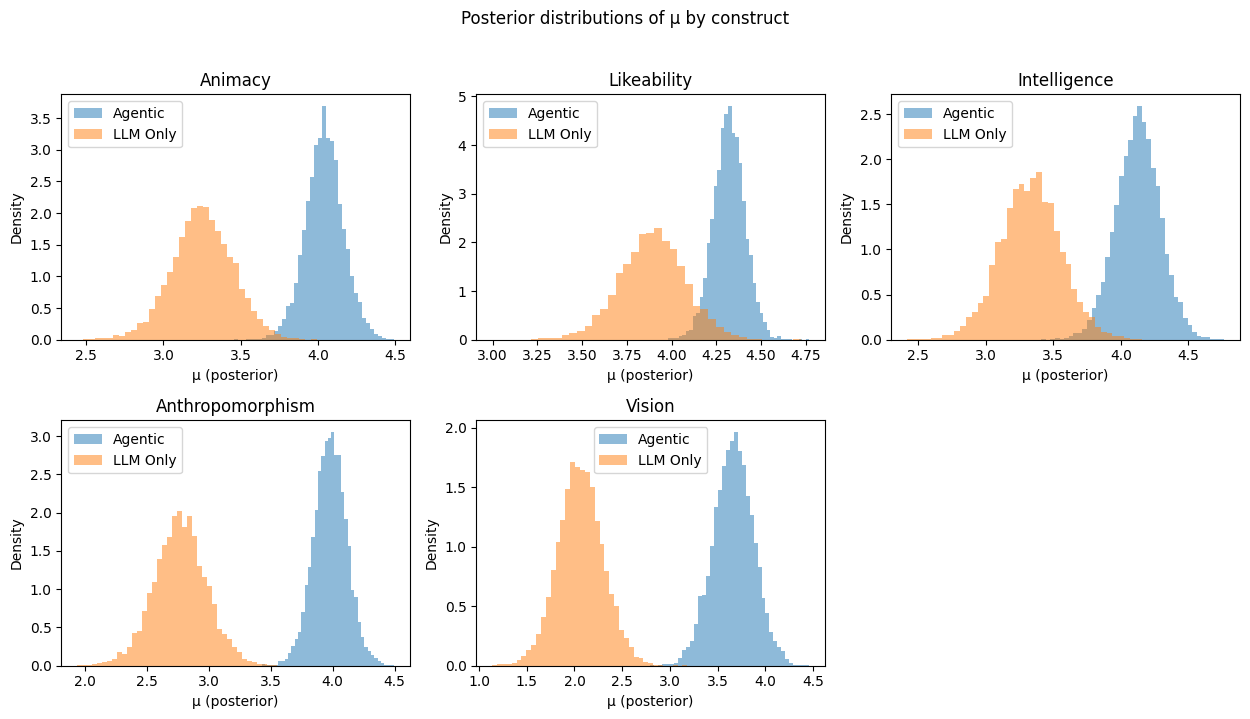

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Reuse your dicts/labels:
# godspeed_groups, constructs, df
SYS_S1 = 'S1_Which system did you interact with?'
SYS_S2 = 'S2_Which system did you interact with?'
AGENTIC = 'Agentic AI based'
LLMONLY = 'Only LLM based'

def collect_system_means(df, godspeed_groups, construct, system_label):
    s1_cols = [c for c in godspeed_groups[construct] if c.startswith('S1_')]
    s2_cols = [c for c in godspeed_groups[construct] if c.startswith('S2_')]
    vals = []
    for _, row in df.iterrows():
        if row[SYS_S1] == system_label and s1_cols:
            m = row[s1_cols].mean()
            if np.isfinite(m): vals.append(float(m))
        if row[SYS_S2] == system_label and s2_cols:
            m = row[s2_cols].mean()
            if np.isfinite(m): vals.append(float(m))
    return np.array(vals, dtype=float)

def fit_mu_posterior(y, lower=1.0, upper=5.0, mu0=3.0, mu_sd=1.0, seed=42):
    y = np.asarray(y, dtype=float)
    with pm.Model() as m:
        mu = pm.TruncatedNormal("mu", mu=mu0, sigma=mu_sd, lower=lower, upper=upper)
        sigma = pm.HalfNormal("sigma", sigma=1.0)
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        idata = pm.sample(draws=2000, tune=1000, chains=4, target_accept=0.9,
                          random_seed=seed, progressbar=False)
    return az.extract(idata, var_names=["mu"]).to_numpy().ravel()

def plot_mu_posteriors(df, godspeed_groups, constructs, lower=1.0, upper=5.0):
    n = len(constructs)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.5*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, c in enumerate(constructs):
        yA = collect_system_means(df, godspeed_groups, c, AGENTIC)
        yL = collect_system_means(df, godspeed_groups, c, LLMONLY)
        if len(yA) < 2 or len(yL) < 2:
            axes[i].axis("off")
            continue

        muA = fit_mu_posterior(yA, lower=lower, upper=upper)
        muL = fit_mu_posterior(yL, lower=lower, upper=upper)

        ax = axes[i]
        # simple kernel-ish density via hist density=True
        ax.hist(muA, bins=40, density=True, alpha=0.5, label="Agentic")
        ax.hist(muL, bins=40, density=True, alpha=0.5, label="LLM Only")
        ax.set_title(c)
        ax.set_xlabel("μ (posterior)")
        ax.set_ylabel("Density")
        ax.legend()

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("Posterior distributions of μ by construct", y=1.02)
    plt.tight_layout()
    plt.show()

# Run it:
plot_mu_posteriors(df, godspeed_groups, constructs, lower=1.0, upper=5.0)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Sampling: [y_obs]


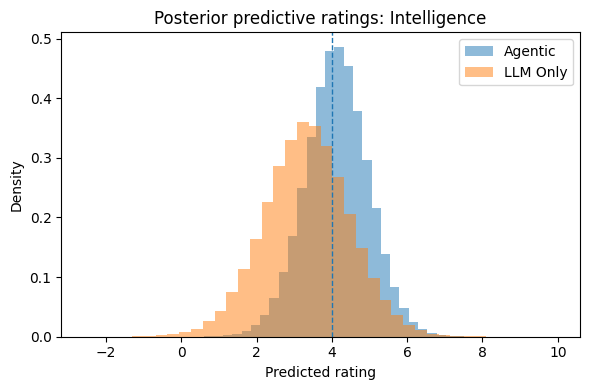

In [ ]:
def posterior_predictive_hist(df, godspeed_groups, construct, lower=1.0, upper=5.0, seed=42):
    # Fit two models and draw posterior predictive
    def fit_and_ppc(y):
        with pm.Model() as m:
            mu = pm.TruncatedNormal("mu", mu=3.0, sigma=1.0, lower=lower, upper=upper)
            sigma = pm.HalfNormal("sigma", sigma=1.0)
            pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
            idata = pm.sample(draws=2000, tune=1000, target_accept=0.9,
                              chains=4, random_seed=seed, progressbar=False)
            ppc = pm.sample_posterior_predictive(idata, random_seed=seed, progressbar=False)
        # robust extraction
        try:
            y_pp = np.asarray(ppc["y_obs"]).ravel()
        except Exception:
            y_pp = np.asarray(ppc.posterior_predictive["y_obs"].values).ravel()
        return y_pp

    yA = collect_system_means(df, godspeed_groups, construct, AGENTIC)
    yL = collect_system_means(df, godspeed_groups, construct, LLMONLY)
    yppA = fit_and_ppc(yA)
    yppL = fit_and_ppc(yL)

    plt.figure(figsize=(6,4))
    plt.hist(yppA, bins=40, density=True, alpha=0.5, label="Agentic")
    plt.hist(yppL, bins=40, density=True, alpha=0.5, label="LLM Only")
    plt.axvline(4, linestyle="--", linewidth=1)  # e.g., "good" threshold
    plt.title(f"Posterior predictive ratings: {construct}")
    plt.xlabel("Predicted rating")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example:
posterior_predictive_hist(df, godspeed_groups, "Intelligence")


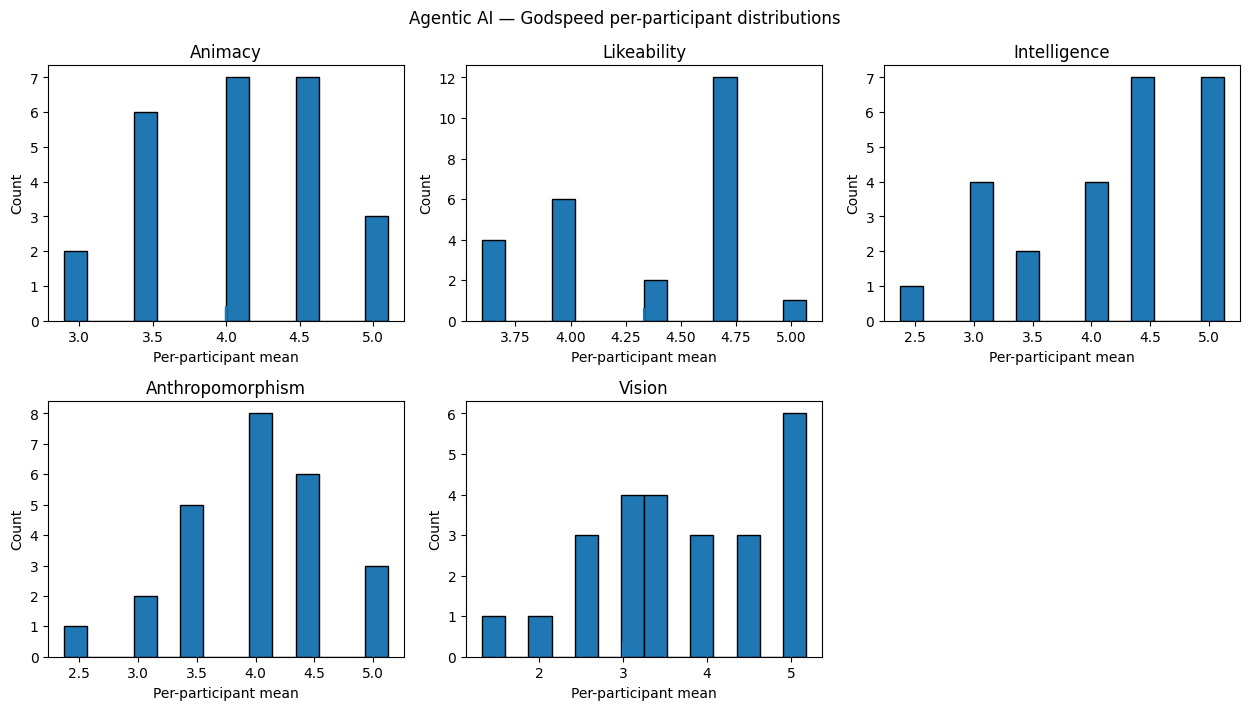

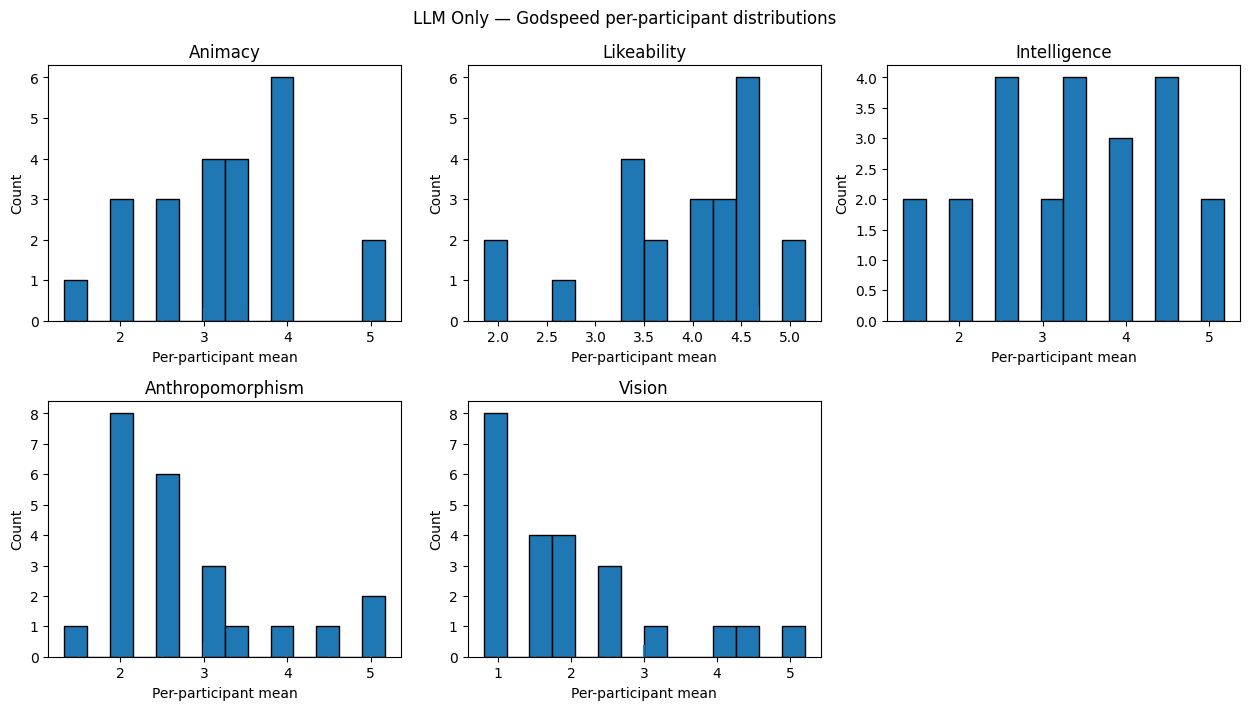

In [19]:
import numpy as np
import matplotlib.pyplot as plt

SYS_S1 = 'S1_Which system did you interact with?'
SYS_S2 = 'S2_Which system did you interact with?'
AGENTIC = 'Agentic AI based'
LLMONLY = 'Only LLM based'

def collect_system_means(df, godspeed_groups, system_label):
    """
    For each construct, collect per-person means for whichever round (S1 or S2)
    the person used `system_label`. Returns dict: {construct: [means...]}.
    """
    out = {c: [] for c in godspeed_groups.keys()}
    for _, row in df.iterrows():
        s1_sys, s2_sys = row[SYS_S1], row[SYS_S2]
        for construct, cols in godspeed_groups.items():
            s1_cols = [c for c in cols if c.startswith('S1_')]
            s2_cols = [c for c in cols if c.startswith('S2_')]

            vals = []
            if s1_sys == system_label and s1_cols:
                vals.append(row[s1_cols].mean())
            if s2_sys == system_label and s2_cols:
                vals.append(row[s2_cols].mean())

            # Append any valid mean(s)
            for v in vals:
                if v is not None and not np.isnan(v):
                    out[construct].append(float(v))
    return out

def nice_bins(values, n_bins=15):
    """Choose bins from data range (handles 1–5 or 1–7 scales gracefully)."""
    if len(values) == 0:
        return np.linspace(0, 1, n_bins)
    vmin, vmax = np.nanmin(values), np.nanmax(values)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = 0.0, 1.0
    pad = 0.05 * (vmax - vmin + 1e-9)
    return np.linspace(vmin - pad, vmax + pad, n_bins)

def plot_histograms_for_system(df, godspeed_groups, constructs, system_label, fig_title):
    """
    One figure with a panel per construct:
      - Histogram of participant means
      - Overlaid dots (all rows/participants) for that construct
    """
    data = collect_system_means(df, godspeed_groups, system_label)

    k = len(constructs)
    ncols = min(3, k)
    nrows = int(np.ceil(k / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.6*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, construct in enumerate(constructs):
        ax = axes[i]
        vals = np.array(data.get(construct, []), dtype=float)
        bins = nice_bins(vals, n_bins=15)

        # Histogram
        ax.hist(vals, bins=bins, edgecolor='black')  # no explicit colors per your requirement

        # Overlay all points as a rug/strip near the x-axis
        if len(vals):
            y0 = ax.get_ylim()[0]
            # Put dots at a small y level (1% of max height) with tiny jitter to avoid overplot
            jitter = (np.random.RandomState(0).rand(len(vals)) - 0.5) * 0.02 * (ax.get_ylim()[1] or 1.0)
            ax.scatter(vals, np.full_like(vals, y0) + 0.02*(ax.get_ylim()[1] or 1.0) + jitter,
                       marker='|', s=100, alpha=0.9)

        ax.set_title(construct)
        ax.set_xlabel('Per-participant mean')
        ax.set_ylabel('Count')

    # Hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(fig_title)
    fig.tight_layout()
    plt.show()

# ==== Make the two required figures ====
plot_histograms_for_system(
    df, godspeed_groups, constructs,
    system_label=AGENTIC,
    fig_title='Agentic AI — Godspeed per-participant distributions'
)

plot_histograms_for_system(
    df, godspeed_groups, constructs,
    system_label=LLMONLY,
    fig_title='LLM Only — Godspeed per-participant distributions'
)
